In [1]:
import osmnx as ox
import networkx as nx
import matplotlib.pyplot as plt

In [ ]:
import geopandas as gpd
from geopy.distance import geodesic
from shapely.geometry import Point, LineString

(<Figure size 800x800 with 1 Axes>, <Axes: >)

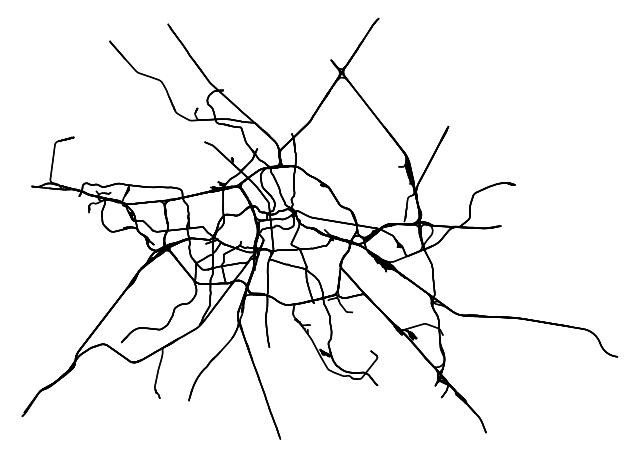

In [2]:
place_name = "Berlin, Germany"

# Train network using railway tag
train_graph = ox.graph_from_place(place_name, network_type="all", custom_filter='["railway"~"rail|light_rail|monorail|subway|tram"]')
# train_graph
ox.plot_graph(train_graph, show=False, close=False, bgcolor='white', node_size=0, edge_color='black')

In [31]:
# you can convert your graph to node and edge GeoPandas GeoDataFrames
gdf_nodes, gdf_edges = ox.convert.graph_to_gdfs(train_graph)
gdf_nodes.head()

,y,x,railway,ref,street_count,geometry
osmid,,,,,,
21302148,52.505414,13.313564,switch,313,3,POINT (13.31356 52.50541)
21302154,52.507410,13.332184,switch,NaN,3,POINT (13.33218 52.50741)
21302159,52.516500,13.338263,switch,NaN,3,POINT (13.33826 52.5165)
21487227,52.511889,13.429512,switch,NaN,3,POINT (13.42951 52.51189)
26124344,52.488632,13.262667,switch,NaN,3,POINT (13.26267 52.48863)


In [15]:
tags = {"public_transport": True}
transport_gdf = ox.features_from_place(place_name, tags)

In [ ]:
# Bus network using route=bus
bus_graph = ox.graph_from_place(place_name, network_type="all", custom_filter='["route"~"bus"]')
bus_graph

In [32]:
# Fetch bus stops from OSM as a GeoDataFrame
bus_stops_gdf = ox.features_from_place(place_name, tags={"highway": "bus_stop"})
bus_stops_gdf = bus_stops_gdf[bus_stops_gdf.geom_type == "Point"]
# Convert to a standard schema for osmnx
bus_stops_gdf = bus_stops_gdf[['geometry']]
bus_stops_gdf['osmid'] = bus_stops_gdf.index  # Set a unique ID for each stop
bus_stops_gdf['y'] = bus_stops_gdf['geometry'].y
bus_stops_gdf['x'] = bus_stops_gdf['geometry'].x

In [40]:
# Nodes GDF already prepared
nodes_gdf = bus_stops_gdf.copy()
nodes_gdf.index = nodes_gdf.index.get_level_values('id')
nodes_gdf.index.names = ['osmid']
nodes_gdf = nodes_gdf.drop(['osmid'], axis=1)
nodes_gdf

,geometry,y,x
osmid,,,
27239370,POINT (13.14494 52.52385),52.523846,13.144936
29846059,POINT (13.16813 52.50874),52.508741,13.168129
29858077,POINT (13.55802 52.54483),52.544833,13.558024
29858105,POINT (13.55772 52.5451),52.545102,13.557721
30134871,POINT (13.25011 52.41885),52.418846,13.250112
...,...,...,...
12439082858,POINT (13.452 52.45316),52.453156,13.451997
12443725089,POINT (13.57761 52.44468),52.444677,13.577606
12449649056,POINT (13.32706 52.60034),52.600337,13.327060


In [ ]:
# Define a threshold distance (meters) for edge creation
max_distance = 500  # meters
edges_list = []

# Generate edges between nodes based on proximity
for idx1, stop1 in bus_stops_gdf.iterrows():
    for idx2, stop2 in bus_stops_gdf.iterrows():
        if idx1 != idx2:
            dist = geodesic(
                (stop1.geometry.y, stop1.geometry.x),
                (stop2.geometry.y, stop2.geometry.x)
            ).meters
            if dist <= max_distance:
                # Create an edge (LineString)
                edge_geom = LineString([stop1.geometry, stop2.geometry])
                edges_list.append({
                    "u": stop1.osmid,
                    "v": stop2.osmid,
                    "length": dist,
                    "geometry": edge_geom
                })

ValueError: `gdf_nodes` must contain 'x' and 'y' columns.

In [ ]:
# Convert to GeoDataFrame
edges_gdf = gpd.GeoDataFrame(edges_list, crs="EPSG:4326")

# Align CRS
nodes_gdf = nodes_gdf.to_crs("EPSG:4326")
# edges_gdf = edges_gdf.to_crs("EPSG:4326")

edges_gdf_c = edges_gdf.copy()
edges_gdf_c['u'] = list(zip(*edges_gdf_c['u']))[1]
edges_gdf_c['v'] = list(zip(*edges_gdf_c['v']))[1]
# If 'key' doesn't exist, create it (for single edges)
edges_gdf_c["key"] = 0  # Assign a default key if edges are unique
# Set 'u' and 'v' as MultiIndex for edges_gdf
edges_gdf_c.set_index(["u", "v", "key"], inplace=True)

# Convert the nodes and edges into a graph
bus_stop_graph = ox.convert.graph_from_gdfs(nodes_gdf, edges_gdf_c)

(<Figure size 800x800 with 1 Axes>, <Axes: >)

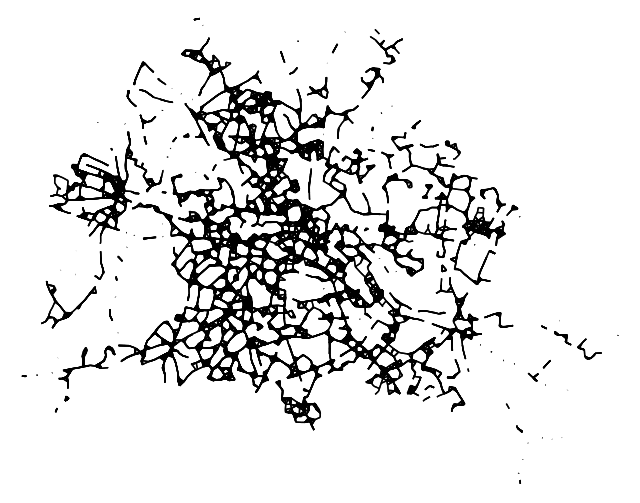

In [64]:
# bus_stop_graph
ox.plot_graph(bus_stop_graph, show=False, close=False, bgcolor='white', node_size=0, edge_color='black')

In [ ]:
# Plot the graph
fig, ax = ox.plot_graph(bus_stop_graph, node_size=20, node_color="red", edge_color="blue", edge_linewidth=1)

<Figure size 1000x1000 with 0 Axes>

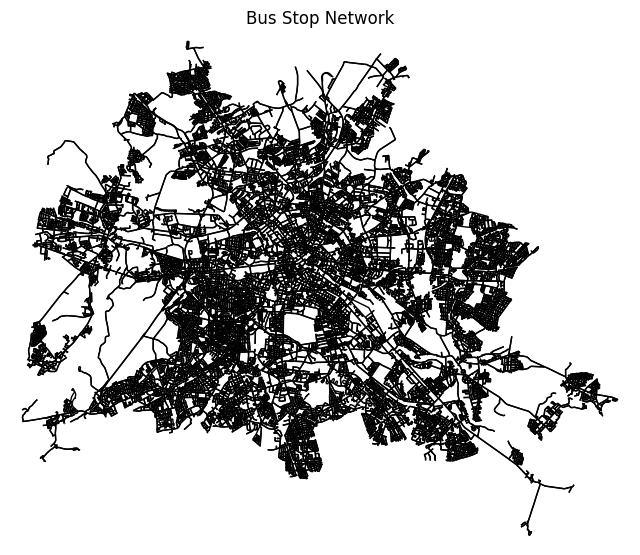

In [21]:
# Plot the bus stop graph with edges (connections) between them
plt.figure(figsize=(10, 10))

# Get the street network as a graph (all street types)
G = ox.graph_from_place(place_name, network_type="drive")

# Plot the basic street network
fig, ax = ox.plot_graph(G, show=False, close=False, bgcolor='white', node_size=0, edge_color='black')

nx.draw(bus_stop_graph, ax=ax, with_labels=False, node_size=10, node_color="red", font_size=10)
plt.title("Bus Stop Network")
plt.show()

In [ ]:
# Merge the graphs
combined_graph = nx.compose(train_graph, bus_stop_graph)

In [ ]:
# Define two points for shortest path calculation
origin_point = (52.5200, 13.4050)  # Berlin Center
destination_point = (52.5159, 13.3777)  # Brandenburg Gate

# Find the nearest nodes on the combined graph
origin_node = ox.distance.nearest_nodes(combined_graph, origin_point[1], origin_point[0])
destination_node = ox.distance.nearest_nodes(combined_graph, destination_point[1], destination_point[0])

In [ ]:
# Compute the shortest path using Dijkstra's algorithm
shortest_path = nx.shortest_path(combined_graph, origin_node, destination_node, weight="length")

# Plot the shortest path
fig, ax = ox.plot_graph_route(combined_graph, shortest_path, route_linewidth=4, node_size=0, bgcolor="white")

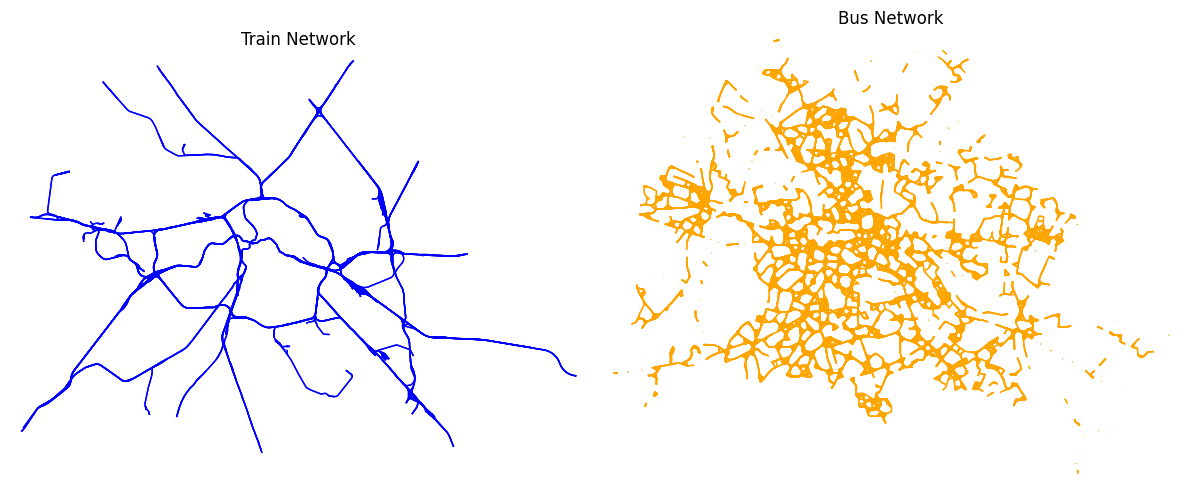

In [68]:
# Plot train and bus graphs separately for clarity
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ox.plot_graph(train_graph, ax=ax[0], node_size=0, edge_color='blue', edge_linewidth=1, show=False)
ox.plot_graph(bus_stop_graph, ax=ax[1], node_size=0, edge_color='orange', edge_linewidth=1, show=False)
ax[0].set_title("Train Network")
ax[1].set_title("Bus Network")
plt.tight_layout()
plt.show()

In [67]:
# # Save the graph as Shapefiles (nodes and edges separately)
# ox.save_graph_shapefile(bus_stop_graph, filepath="data/graph_bus_stop")
# Save the graph to a GraphML file
ox.io.save_graphml(bus_stop_graph, filepath="data/graph_bus_stop.graphml")
ox.io.save_graphml(train_graph, filepath="data/graph_train.graphml")